In [1]:
import numpy as np
import matplotlib.pyplot as plt
rnd = np.random.RandomState(42) # for reproducibility

# CREATE MOCK NOISY DATA

## Define true slope $m$ and intercept $b$

In [2]:
m_true = 1.255
b_true = 4.507

## Create mock noiseless predictions, $\quad y_i^{\rm{noiseless}} = m x_i + b$

In [3]:
ndatapoints = 20
x_i = np.linspace(0, 1, ndatapoints)

def model_linear(x, m, b):
    return m * x + b

y_i_noiseless = model_linear(x_i, m_true, b_true)

## Add Gaussian noise,             $\quad y_i \sim \cal{N} (y_i^{\rm{noiseless}}, \sigma_{i}^2)$

In [4]:
sigma_i = rnd.uniform(0.1, 0.2, size=ndatapoints)  # randomly generate uncertainty for each datum
y_i = rnd.normal(y_i_noiseless, sigma_i)  # add Gaussian noise to the data points

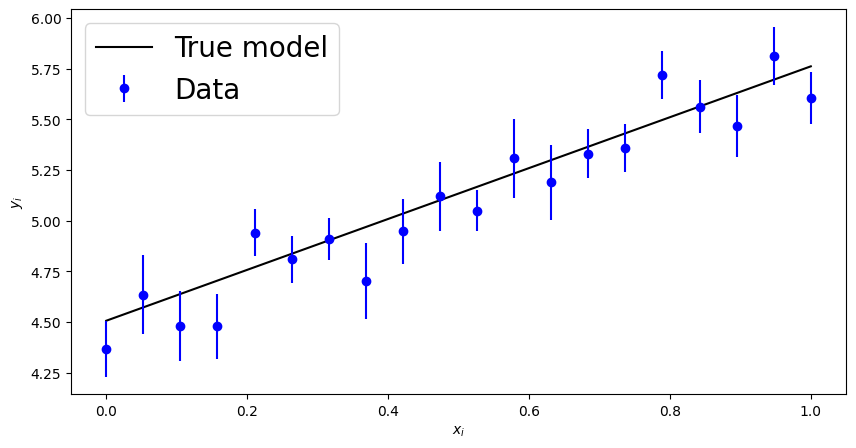

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(x_i, model_linear(x_i, m_true, b_true), color='black', label='True model')
plt.errorbar(x_i, y_i, sigma_i, fmt='o', color='blue', label='Data')
plt.xlabel('$x_i$')
plt.ylabel('$y_i$')
plt.legend(loc='upper left', fontsize=20)

# BAYESIAN INFERENCE PIPELINE
Define PRIOR, LIKELIHOOD, POSTERIOR. We will work with log-quantities, as computationally more stable

Uniform priors in $m$ and $b$
 
$m \sim \cal{U} (0, 100)$

$b \sim \cal{U} (-50, 50)$

In [6]:
def ln_prior(params):
    r"""Logarithm of Uniform prior on the slope and intercept.
    m in [-100, 100]
    b in [-50, 50]
    """
    slope, intercept = params
    ln_prior_val = 0.0  # we'll add to this value as we go along
    # check to see if the slope and intercept are within the bounds
    if slope < 0 or slope > 100. or intercept < -50. or intercept > 50.:
        return - np.inf
    else:
        ln_prior_val += 2*np.log(1/100) # log(1/100), since m in [0, 100], b in [-50, 50]
    return ln_prior_val

Gaussian likelihood, $\cal{L} (y_i | {m, b}) \sim \cal{N}(y_i^{noiseless} = m x_i + b, \, \sigma_i^2)$

In [7]:
def ln_likelihood(params):
    r"""Logarithm of Gaussian likelihood function because we have Gaussian noise.
    """
    m, b = params
    model_y_i = model_linear(x_i, m, b)
    return np.sum(-0.5 * ((y_i - model_y_i) / sigma_i)**2) # log of Gaussian up to normalisation

posterior $p({m, b} | y_i)$ $\propto$ likelihood $\times$ prior $\implies$ log-posterior $\propto$ log-likelihood + log-prior 

In [8]:
def ln_posterior(params):
    r"""The log-posterior is the sum of the log-prior and the log-likelihood.
    """
    lnprior_val = ln_prior(params)
    # if the prior is not finite return a probability of zero (log probability of -inf)
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    # else return the likelihood times the prior (log likelihood + the log prior)
    else:           
        lnlike_val = ln_likelihood(params)
        return lnprior_val + lnlike_val


# OBTAINING THE POSTERIOR

In [9]:
# helper function to evaluate the log-prior, log-likelihood and log-posterior on a grid
def evaluate_on_grid(func, slope_grid, intercept_grid):
    slope_grid, intercept_grid = np.meshgrid(slope_grid, intercept_grid)
    slope_intercept_grid = np.vstack((slope_grid.ravel(), intercept_grid.ravel())).T

    func_vals = np.zeros(slope_intercept_grid.shape[0])
    for j, pars in enumerate(slope_intercept_grid):
        func_vals[j] = func(pars)

    return func_vals.reshape(slope_grid.shape)

In [10]:
# make a 256x256 grid of parameter values centered on the true values
m_grid = np.linspace(m_true - 5.0, m_true + 5, 256)
b_grid = np.linspace(b_true - 5.0, b_true + 5, 256)

# evaluate the log-prior, log-likelihood, and log-posterior on the grid
ln_prior_vals = evaluate_on_grid(ln_prior, m_grid, b_grid)
ln_like_vals = evaluate_on_grid(ln_likelihood, m_grid, b_grid)
ln_post_vals = evaluate_on_grid(ln_posterior, m_grid, b_grid)

# PLOTTING

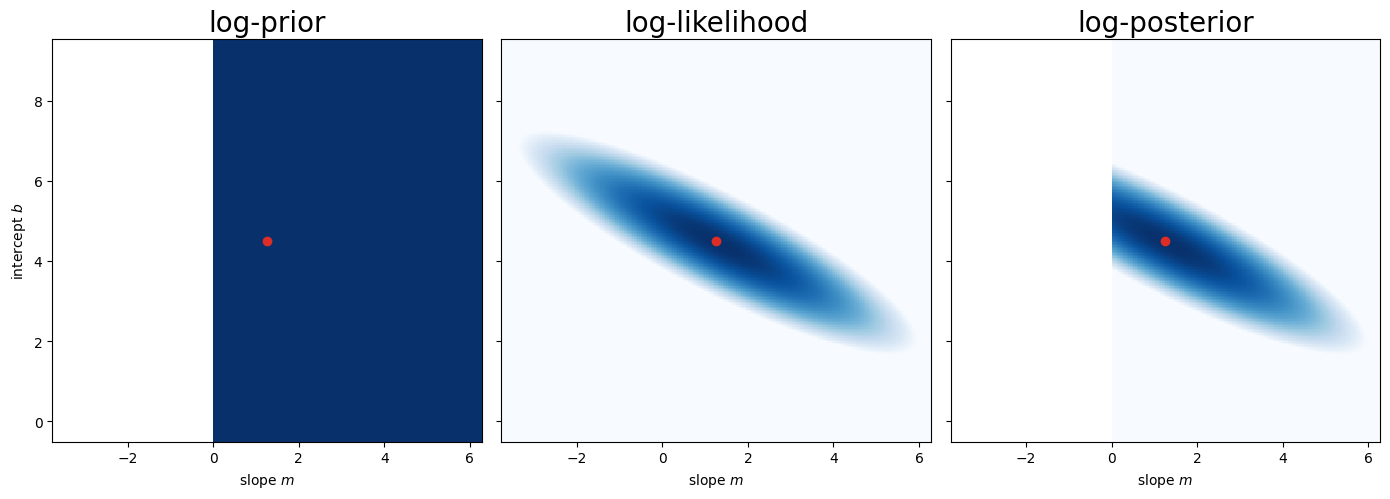

In [11]:

# plot the log-prior, log-likelihood, and log-posterior on the grid of m and b values
fig, axes = plt.subplots(1, 3, figsize=(14, 5.1), sharex=True, sharey=True)
for i, vals in enumerate([ln_prior_vals, ln_like_vals, ln_post_vals]):
    axes[i].pcolormesh(m_grid, b_grid, vals, cmap="Blues", vmin=vals.max() - 1024, vmax=vals.max())
axes[0].set_title("log-prior", fontsize=20)
axes[1].set_title("log-likelihood", fontsize=20)
axes[2].set_title("log-posterior", fontsize=20)
for ax in axes:
    ax.set_xlabel("slope $m$")
    # plot the truth
    ax.plot(m_true, b_true, marker="o", zorder=10, color="#de2d26")
    ax.axis("tight")
axes[0].set_ylabel("intercept $b$")
fig.tight_layout()